In [46]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42433")

# Import

In [2]:
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
from IPython import display
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,Callback
import inspect
import itertools
import matplotlib.colors as mcolors
import glob, os
from random import randrange

In [3]:
import myParam3Ddata
import myTorchModels3D

In [4]:
import importlib

In [5]:
importlib.reload(myParam3Ddata)

<module 'myParam3Ddata' from '/home/jovyan/oceanDataNotebooks/density_ML/myParam3Ddata.py'>

# Prepare data

In [6]:
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET'] 

In [7]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL FMA'})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL ASO'})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

In [8]:
features_to_add_to_sample = ['votemper', 'votemper_var', 'rho_ct_ct', 'diff_votemper_sqr']

In [9]:
auxiliary_features = ['z_l', 'f', 'e1t', 'e2t']

In [10]:
batch_size = 4

In [11]:
%%time
all_data = myParam3Ddata.PyLiDataModule(data_dict, features_to_add_to_sample, auxiliary_features, batch_size=batch_size)

CPU times: user 16.5 s, sys: 4.59 s, total: 21.1 s
Wall time: 1min 46s


# Test finite diffrences

In [12]:
all_data.prepare_data()

In [13]:
all_data.setup(stage='fit')

In [14]:
test_dl = all_data.train_dataloader()

In [15]:
test_di = iter(test_dl)

In [16]:
sample = next(test_di)

In [17]:
batch_len = sample['votemper'].shape[0]

In [18]:
nb_levels = sample['votemper'].shape[1]

In [19]:
weights = torch.zeros(2,1,3,3)

In [20]:
weights[0,0,:,:] = torch.tensor([[0,0.,0],[-0.5,0.,0.5],[0,0.,0]])
weights[1,0,:,:] = torch.tensor([[0,-0.5,0],[0,0.,0],[0,0.5,0]])

In [21]:
weights.shape

torch.Size([2, 1, 3, 3])

In [22]:
data = sample['votemper']

In [23]:
data.shape

torch.Size([4, 107, 45, 40])

In [24]:
%%time
res1 = torch.nn.functional.conv2d(data.flatten(start_dim=0, end_dim=1)[:,None,:,:], \
                           weights, \
                           bias=None, stride=1, padding='same', dilation=1, groups=1)
res1_dx = res1[:,0,:,:].unflatten(dim=0, sizes=(batch_len, nb_levels))
res1_dy = res1[:,1,:,:].unflatten(dim=0, sizes=(batch_len, nb_levels))

CPU times: user 288 ms, sys: 7.65 ms, total: 295 ms
Wall time: 49.4 ms


In [25]:
%%time
res2_dx = 0.5*(torch.roll(data, shifts=-1, dims=3) - torch.roll(data, shifts=1, dims=3))
res2_dy = 0.5*(torch.roll(data, shifts=-1, dims=2) - torch.roll(data, shifts=1, dims=2))

CPU times: user 39.7 ms, sys: 7.9 ms, total: 47.6 ms
Wall time: 6.87 ms


In [26]:
res1.shape

torch.Size([428, 2, 45, 40])

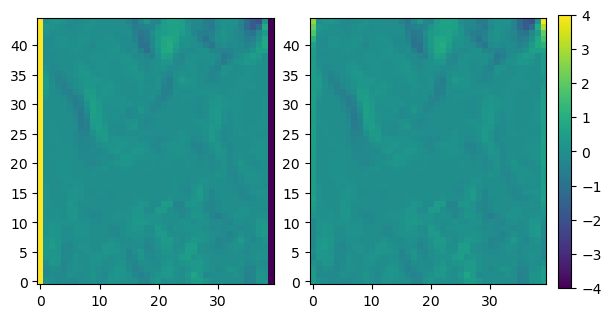

In [27]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3.5))
index = 0
ax[0].imshow(res1_dx[index,0,:,:], vmin=-4, vmax=4, origin='lower')
img = ax[1].imshow(res2_dx[index,0,:,:], vmin=-4, vmax=4, origin='lower')
fig.colorbar(img, ax=ax[-1], shrink=0.8)
plt.show()

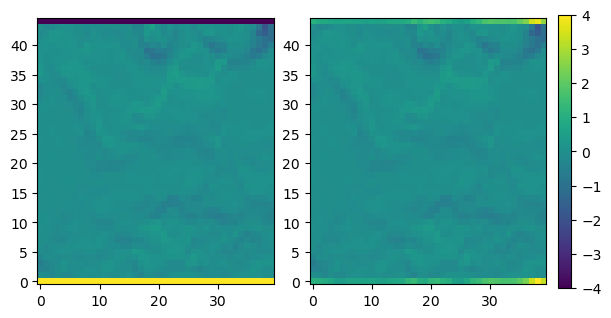

In [28]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3.5))
index = 0
ax[0].imshow(res1_dy[index,0,:,:], vmin=-4, vmax=4, origin='lower')
img = ax[1].imshow(res2_dy[index,0,:,:], vmin=-4, vmax=4, origin='lower')
fig.colorbar(img, ax=ax[-1], shrink=0.8)
plt.show()

In [29]:
# compare in x direction
torch.testing.assert_close(res1_dx[:,:,1:-1,1:-1], res2_dx[:,:,1:-1,1:-1]) 

In [30]:
# compare in y direction
torch.testing.assert_close(res1_dy[:,:,1:-1,1:-1], res2_dy[:,:,1:-1,1:-1]) 

In [31]:
res_x, res_y = myParam3Ddata.central_diffs(data)

In [32]:
torch.testing.assert_close(res2_dx[:,:,1:-1,1:-1], res_x) 

In [33]:
torch.testing.assert_close(res2_dy[:,:,1:-1,1:-1], res_y) 

In [34]:
myParam3Ddata.finite_diffs_sqr_2d_array(data).shape

torch.Size([4, 107, 43, 38])

In [35]:
res = myParam3Ddata.get_pressure_grad(sample['votemper_var'].float() , sample['rho_ct_ct'].float() , dx=sample['e1t'], dy=sample['e2t'])

In [36]:
res[-1].shape

torch.Size([4, 106, 43, 38])

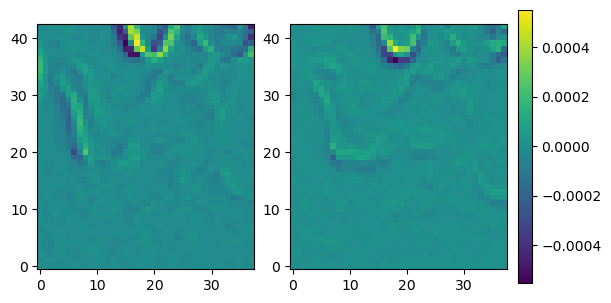

In [37]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3.5))
index = 0
ax[0].imshow(res[0][index,-1,:,:], origin='lower')
img = ax[1].imshow(res[1][index,-1,:,:], origin='lower')
fig.colorbar(img, ax=ax[-1], shrink=0.8)
plt.show()

# Test averaging with convolutions

In [38]:
weights = torch.ones(1,1,3,3)

In [39]:
weights

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [40]:
padding = torch.nn.ReplicationPad2d(1)

In [41]:
data = data[:,:,1:10,1:10]

In [42]:
padded_data = padding(data)

In [43]:
data.shape

torch.Size([4, 107, 9, 9])

In [44]:
padded_data.shape

torch.Size([4, 107, 11, 11])

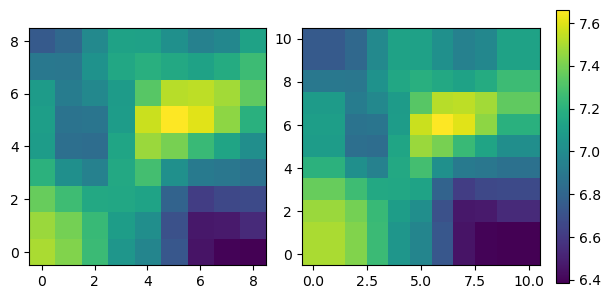

In [45]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3.5))
index = 0
ax[0].imshow(data[index,-1,:,:], origin='lower')
img = ax[1].imshow(padded_data[index,-1,:,:], origin='lower')
fig.colorbar(img, ax=ax[-1], shrink=0.8)
plt.show()